In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# 設定設備為MPS（如果你的設備支援）
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 資料路徑
train_def_front = "/Users/linyinghsiao/Desktop/github專案/鑄造產品質量檢查/data/casting_data/train/def_front"
train_ok_front = "/Users/linyinghsiao/Desktop/github專案/鑄造產品質量檢查/data/casting_data/train/ok_front"
test_def_front = "/Users/linyinghsiao/Desktop/github專案/鑄造產品質量檢查/data/casting_data/test/def_front"
test_ok_front = "/Users/linyinghsiao/Desktop/github專案/鑄造產品質量檢查/data/casting_data/test/ok_front"

# 定義資料轉換
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# 載入訓練資料
train_data = ImageFolder(root='/Users/linyinghsiao/Desktop/github專案/鑄造產品質量檢查/data/casting_data/train', transform=transform)

# 載入測試資料
test_data = ImageFolder(root='/Users/linyinghsiao/Desktop/github專案/鑄造產品質量檢查/data/casting_data/test', transform=transform)

# 資料分割
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# 建立資料加載器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        #input (3,128,128) 
        x = self.pool(F.relu(self.conv1(x))) # (32, 64, 64)
        x = self.pool(F.relu(self.conv2(x))) # (64, 32, 32)
        x = x.view(-1, 64 * 32 * 32) #(1, 64*32*32)
        x = F.relu(self.fc1(x)) #(64*32*32, 512)
        x = self.dropout(x)
        x = self.fc2(x) #(512,2)
        return x
    

model = CNN().to(device)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # 驗證模型
    model.eval()
    val_labels = []
    val_preds = []
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(preds.cpu().numpy())
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


In [ ]:
# 畫圖比較 training loss vs validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()

# 畫圖比較 training accuracy vs validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Train Epoch: 1 [0/5306 (0%)]	Loss: 0.694353
Train Epoch: 1 [640/5306 (12%)]	Loss: 0.852340
Train Epoch: 1 [1280/5306 (24%)]	Loss: 0.576717
Train Epoch: 1 [1920/5306 (36%)]	Loss: 0.378139
Train Epoch: 1 [2560/5306 (48%)]	Loss: 0.412386
Train Epoch: 1 [3200/5306 (60%)]	Loss: 0.270905
Train Epoch: 1 [3840/5306 (72%)]	Loss: 0.220057
Train Epoch: 1 [4480/5306 (84%)]	Loss: 0.303058
Train Epoch: 1 [5120/5306 (96%)]	Loss: 0.253707

Validation set: Average loss: 0.0037, Accuracy: 1197/1327 (90.20%)

Train Epoch: 2 [0/5306 (0%)]	Loss: 0.210974
Train Epoch: 2 [640/5306 (12%)]	Loss: 0.274253
Train Epoch: 2 [1280/5306 (24%)]	Loss: 0.200845
Train Epoch: 2 [1920/5306 (36%)]	Loss: 0.150148
Train Epoch: 2 [2560/5306 (48%)]	Loss: 0.085598
Train Epoch: 2 [3200/5306 (60%)]	Loss: 0.132126
Train Epoch: 2 [3840/5306 (72%)]	Loss: 0.217017
Train Epoch: 2 [4480/5306 (84%)]	Loss: 0.154201
Train Epoch: 2 [5120/5306 (96%)]	Loss: 0.181690

Validation set: Average loss: 0.0023, Accuracy: 1272/1327 (95.86%)

Train Ep

/var/folders/1s/_20v_50n7xsc4yy6kvyfs8500000gn/T/ipykernel_80922/1301827520.py:208: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  cam = grad_cam.generate(torch.tensor(all_images[i:i+1]).to(device))


Saving Gram cad plot...


ValueError: x and y must have same first dimension, but have shapes (10,) and (5,)

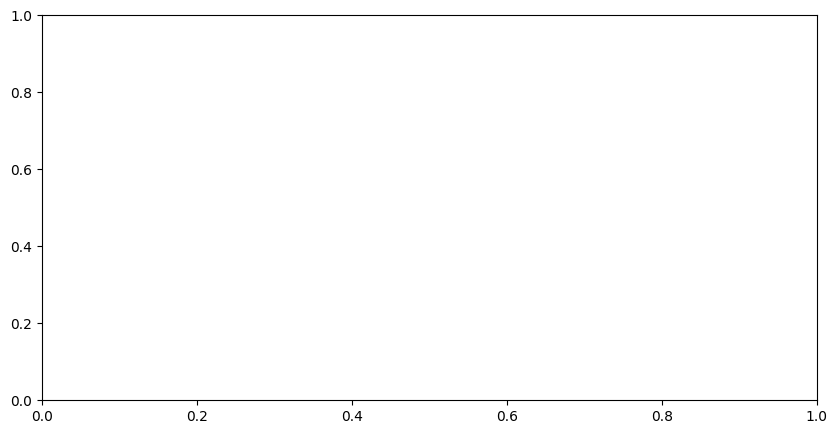

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Normalize, Compose
import numpy as np
import cv2
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
# 定义数据预处理
transform = Compose([
    Resize((128, 128)),  # 假设图像为128x128大小，如果不是则调整
    ToTensor(),
    Normalize((0.5,), (0.5,))  # 根据图像的实际情况进行调整
])

# 加载训练和测试数据集
train_dataset = ImageFolder(root=r"/Users/linyinghsiao/Desktop/github專案/鑄造產品質量檢查/data/casting_data/train", transform=transform)
test_dataset = ImageFolder(root=r"/Users/linyinghsiao/Desktop/github專案/鑄造產品質量檢查/data/casting_data/test", transform=transform)

# 将训练集进一步划分为训练集和验证集
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义模型
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1, padding=0) 
        
        # 使用一个假的输入来计算全连接层的输入大小
        self._initialize_fc()

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.5)

    def _initialize_fc(self):
        # 使用一个假的输入计算卷积和池化层后的输出形状
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 128, 128)  # 假设输入大小为 (3, 128, 128)
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool(F.relu(self.conv2(x)))
            self.flattened_size = x.numel()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # 自动计算需要的形状
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = CNN()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练函数
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = len(train_loader.dataset)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()  # 累加损失
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        # 计算进度
        current_progress = batch_idx * len(data)
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{current_progress}/{total} '
                  f'({100. * current_progress / total:.0f}%)]\tLoss: {loss.item():.6f}')

    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    
    return train_loss, accuracy

# 验证函数
def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()  # 累加损失
            pred = output.argmax(dim=1, keepdim=True)  # 取概率最大的类别
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    print(f'\nValidation set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)}'
          f' ({accuracy:.2f}%)\n')
    
    return val_loss, accuracy

# 通用评估函数，用于测试和可视化
def evaluate_model(model, device, data_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    all_images = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_images.extend(data.cpu().numpy())

    test_loss /= len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)

    return test_loss, accuracy, all_preds, all_targets, all_images

# 测试模型
def test(model, device, test_loader):
    test_loss, accuracy, _, _, _ = evaluate_model(model, device, test_loader)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%\n')

# Grad-CAM 实现
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)  

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_image, class_idx=None):
        self.model.eval()
        output = self.model(input_image)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        output[:, class_idx].backward()

        gradients = self.gradients[0]
        activations = self.activations[0]

        weights = torch.mean(gradients, dim=(1, 2), keepdim=True)
        cam = torch.sum(weights * activations, dim=0)

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        cam = cam.cpu().numpy()

        cam = cv2.resize(cam, (input_image.size(3), input_image.size(2)))

        return cam
    
# Grad-CAM 可视化
def visualize_gradcam(model, device, data_loader, target_layer, num_images=9):
    _, _, all_preds, all_targets, all_images = evaluate_model(model, device, data_loader)
    grad_cam = GradCAM(model, target_layer)

    # 可视化部分结果
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    for i, ax in enumerate(axes[:num_images]):
        img = all_images[i].transpose(1, 2, 0)  # 调整维度以显示图像
        img = (img * 0.5) + 0.5  # 反归一化

        # Generate Grad-CAM for the image
        cam = grad_cam.generate(torch.tensor(all_images[i:i+1]).to(device))

        # Display the image with the heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        superimposed_img = heatmap + img
        superimposed_img = superimposed_img / np.max(superimposed_img)

        ax.imshow(superimposed_img)
        ax.set_title(f'Pred: {all_preds[i][0]}, True: {all_targets[i]}')
        ax.axis('off')
    plt.tight_layout()
    print("Saving Gram cad plot...")
    plt.savefig(r"/Users/linyinghsiao/Desktop/github專案/鑄造產品質量檢查/gram.png")
    plt.close()

# 训练和验证模型
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(1, 6):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    val_loss, val_accuracy = validate(model, device, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

# 测试模型
test(model, device, test_loader)


Saving Gram cad plot...
Saving training and validation loss plot...


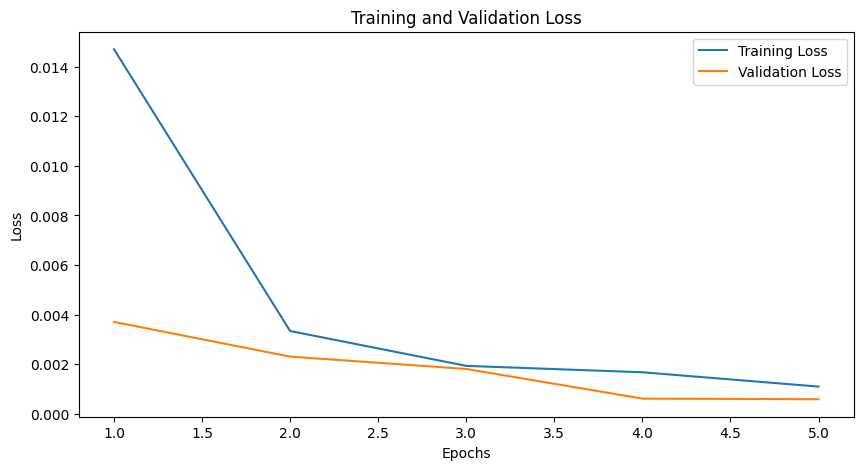

Saving training and validation accuracy plot...


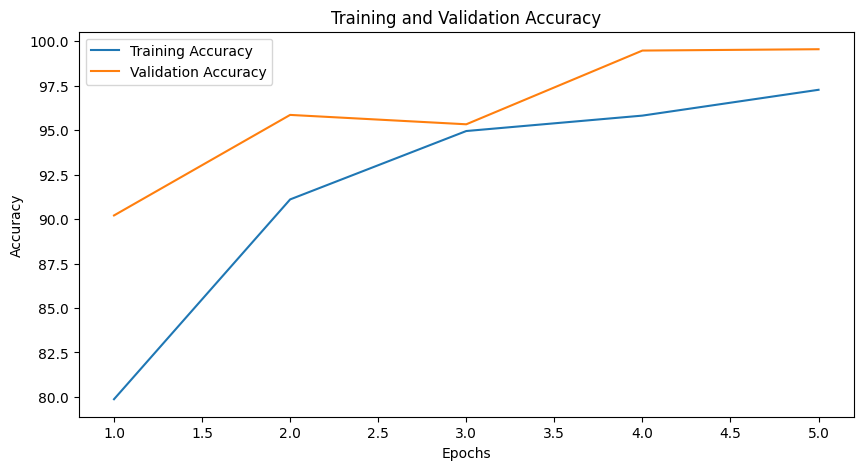

In [47]:
def visualize_gradcam(model, device, data_loader, target_layer, num_images=16):
    _, _, all_preds, all_targets, all_images = evaluate_model(model, device, data_loader)
    grad_cam = GradCAM(model, target_layer)

    # 可视化部分结果
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()
    for i, ax in enumerate(axes[:num_images]):
        img = all_images[i].transpose(1, 2, 0)  # 调整维度以显示图像
        img = (img * 0.5) + 0.5  # 反归一化

        # Generate Grad-CAM for the image
        cam = grad_cam.generate(torch.tensor(all_images[i:i+1]).to(device))

        # Display the image with the heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        superimposed_img = heatmap + img
        superimposed_img = superimposed_img / np.max(superimposed_img)

        ax.imshow(superimposed_img)
        ax.set_title(f'Pred: {all_preds[i][0]}, True: {all_targets[i]}')
        ax.axis('off')
    plt.tight_layout()
    print("Saving Gram cad plot...")
    plt.savefig(r"/Users/linyinghsiao/Desktop/github專案/鑄造產品質量檢查/gram.png")
    plt.close()


# 进行 Grad-CAM 可视化
visualize_gradcam(model, device, test_loader, model.conv2)

# 绘制训练和验证的 Loss 曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), train_losses, label='Training Loss')
plt.plot(range(1, 6), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
print("Saving training and validation loss plot...")
#plt.savefig(r"C:\Users\Ivan_Lin\Desktop\stub length\Test_streamlit_ALLpy\training_validation_loss.png")
plt.show()  # 显示图像
plt.close()

# 绘制训练和验证的 Accuracy 曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 6), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
print("Saving training and validation accuracy plot...")
#plt.savefig(r"C:\Users\Ivan_Lin\Desktop\stub length\Test_streamlit_ALLpy\training_validation_accuracy.png")
plt.show()  # 显示图像
plt.close()